# Convert a TensorFlow Model to OpenVINO™

This short tutorial shows how to convert a TensorFlow [MobileNetV3](https://docs.openvino.ai/latest/omz_models_model_mobilenet_v3_small_1_0_224_tf.html) image classification model to OpenVINO [Intermediate Representation](https://docs.openvino.ai/latest/openvino_docs_MO_DG_IR_and_opsets.html) (OpenVINO IR) format, using [Model Optimizer](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html). After creating the OpenVINO IR, load the model in [OpenVINO Runtime](https://docs.openvino.ai/latest/openvino_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html) and do inference with a sample image.  

## Imports

In [1]:
import time
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown
import openvino.runtime as ov
from openvino.runtime import Core, Layout, Type

## Settings

In [2]:
# The paths of the source and converted models.
model_path = Path("/home/fiborobotlab/models/classification/chess/MobileNetV2_binary/saved_model.pb")
# model_path = Path("/home/fiborobotlab/models/classification/chess/MobileNetV2_color/saved_model.pb")
ir_path = Path(model_path).with_suffix(".xml")

## Convert a Model to OpenVINO IR Format

### Convert a TensorFlow Model to OpenVINO IR Format

Use Model Optimizer to convert a TensorFlow model to OpenVINO IR with `FP16` precision. The models are saved to the current directory. Add mean values to the model and scale the output with the standard deviation with `--scale_values`. With these options, it is not necessary to normalize input data before propagating it through the network. The original model expects input images in `RGB` format. The converted model also expects images in `RGB` format. If you want the converted model to work with `BGR` images, use the `--reverse-input-channels` option. For more information about Model Optimizer, including a description of the command-line options, see the [Model Optimizer Developer Guide](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html). For information about the model, including input shape, expected color order and mean values, refer to the [model documentation](https://docs.openvino.ai/latest/omz_models_model_mobilenet_v3_small_1_0_224_tf.html).

First construct the command for Model Optimizer, and then execute this command in the notebook by prepending the command with an `!`. There may be some errors or warnings in the output. When model optimization is successful, the last lines of the output will include `[ SUCCESS ] Generated IR version 11 model.`

In [3]:
# Construct the command for Model Optimizer.
mo_command = f"""mo
                 --saved_model_dir "{model_path.parent}"
                 --input_shape "[-1,224,224,3]"
                 --mean_values="[123,117,104]"
                 --scale 255
                 --data_type FP32
                 --framework="tf"
                 --reverse_input_channels
                 # --disable_nhwc_to_nchw
                 --progress
                 --output_dir "{model_path.parent}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert TensorFlow to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert TensorFlow to OpenVINO:


`mo --saved_model_dir "/home/fiborobotlab/models/classification/chess/MobileNetV2_binary" --input_shape "[-1,224,224,3]" --mean_values="[127.5, 127.5, 127.5]" --scale_values="[255, 255, 255]" --data_type FP32 --framework="tf" # --disable_nhwc_to_nchw --output_dir "/home/fiborobotlab/models/classification/chess/MobileNetV2_binary"`

In [4]:
# Run Model Optimizer
! $mo_command

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/home/fiborobotlab/dev_ws/src/module89/scripts/utils/.
	- IR output name: 	saved_model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[-1,224,224,3]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	[127.5, 127.5, 127.5]
	- Scale values: 	[255, 255, 255]
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Frontend of Model Optimizer for model conversion into IR: 	False
	- Force the usage of new Frontend of Model Opti

## Test Inference on the Converted Model

### Load an Image

Load an image, resize it, and convert it to the input shape of the network.

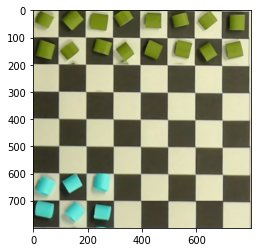

In [5]:
# The MobileNet network expects images in RGB format.
image = cv2.imread("../test_CNNinputs.png")
# image = cv2.cvtColor(image, code=cv2.COLOR_BGR2RGB)
plt.imshow(image)
CNNinputs_resized = []
for i in range(8):
    for j in range(8):
        tile_img = image[100*i:100*(i+1),100*j:100*(j+1)]
        # Resize the image to the network input shape.
        resized_image = cv2.resize(src=tile_img, dsize=(224, 224))
        # Transpose the image to the network input shape.
        input_image = np.expand_dims(resized_image, 0)
        CNNinputs_resized.append(input_image)

### Load the Model (batched inference)

In [31]:
ie = Core()
print("Avaliable devices:")
print(ie.available_devices)
model = ie.read_model(model=ir_path, weights=ir_path.with_suffix(".bin"))
model.reshape([64, 224, 224, 3])
# compiled_model = ie.compile_model(model=model, device_name="CPU")
compiled_model = ie.compile_model(model, "GPU", {"PERFORMANCE_HINT": "THROUGHPUT"})
# get model information
input_key = compiled_model.input(0)
print(input_key)
output_key = compiled_model.output(0)
print(output_key)
network_input_shape = input_key.shape
print(network_input_shape)

Avaliable devices:
['CPU', 'GNA', 'GPU']
<ConstOutput: names[input_2:0, input_2] shape{64,224,224,3} type: f32>
<ConstOutput: names[StatefulPartitionedCall/model/dense/BiasAdd:0, StatefulPartitionedCall/Identity:0, Identity:0, Func/StatefulPartitionedCall/output/_263:0] shape{64,1} type: f32>
{64, 224, 224, 3}


In [32]:
## Do Inference
infer_request = compiled_model.create_infer_request()
# Set the tensor as an input for the infer request
infer_request.infer([CNNinputs_resized])
output_tensor = infer_request.get_output_tensor()
result = output_tensor.data[:].reshape(8, 8)
print(result)
board_result_binary = np.where(result < 0, 0, 1)   # Interpreted prediction
print(board_result_binary)
# result = compiled_model(CNNinputs_resized)[output_key]
# print(result)

        # result_index = np.argmax(result)
        # plt.imshow(tile_img)
        # print(result_index)

[[-5.74296    -4.121631    0.353961   -3.3458376   0.89691263  2.0507882
  -1.9334943  12.516378  ]
 [ 4.7855983  -2.6059208  -0.83686376 -2.7643826   0.60897434  3.635102
  -0.14697996 -1.1242044 ]
 [-4.424594   -2.6034884  -4.9685473  -2.3608437  -4.3985157  -3.472271
  -4.7044435  -3.102599  ]
 [-3.6533344  -4.398923   -2.7858288  -4.5818706  -2.8790107  -4.29745
  -3.3945909  -4.587485  ]
 [-4.5371504  -2.578376   -4.259781   -2.136626   -4.4344625  -3.5560904
  -4.8985686  -3.8899374 ]
 [-3.358726   -3.3908951  -2.7799194  -4.909074   -3.4757736  -4.7601986
  -3.9954927  -4.508716  ]
 [-3.002046   -2.3928483  -2.386294   -2.9928868  -4.3285184  -3.8296776
  -4.9527106  -3.8541656 ]
 [-6.4984264  -6.607061   -1.6534636  -4.12535    -4.629403   -5.1775002
  -5.138366   -4.80675   ]]
[[0 0 1 0 1 1 0 1]
 [1 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


### Load the model (dynamic batch inference)

In [ ]:
from openvino.preprocess import PrePostProcessor, ResizeAlgorithm
ie = Core()
print("Avaliable devices:")
print(ie.available_devices)
model = ie.read_model(model=ir_path)
# for output_key in model.outputs:
#     for op in model.get_ops():
#         if op.get_type_name() == 'Convolution':
#             output_name, output_info = output_key, model.outputs[output_key.get_index()]
if len(model.inputs) != 1:
    print('Sample supports only single input topologies')
if len(model.outputs) != 1:
    print('Sample supports only single output topologies')

input_tensor = np.array(CNNinputs_resized, dtype=np.uint8).reshape(-1, 224, 224, 3)
ppp = PrePostProcessor(model)
_, h, w, _ = input_tensor.shape
ppp.input().tensor() \
        .set_element_type(Type.u8) \
        .set_layout(Layout('NHWC')) \
        .set_spatial_static_shape(h, w)  # noqa: ECE001, N400
ppp.input().preprocess().resize(ResizeAlgorithm.RESIZE_LINEAR)
# ppp.input().model().set_layout(Layout('NCHW'))
ppp.output().tensor().set_element_type(Type.f16)
model = ppp.build()
compiled_model = ie.compile_model(model, 'CPU')
output_key = compiled_model.output(0)
results = compiled_model.infer_new_request({0: input_tensor})[output_key].reshape(8, 8)
print(results)
board_result_binary = np.where(results < 0, 0, 1)   # Interpreted prediction
print(board_result_binary)